In [9]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import os
import PIL

#split
import shutil
from sklearn.model_selection import train_test_split
import keras
import tensorflow.keras as keras
import tensorflow as tf
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score, classification_report

from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.applications import DenseNet169
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam

In [10]:
# dir dataset
source_dir = 'C:/Users/riski/Documents/Anorganik/dataset2/'

# dir tujuan
base_dir = 'C:/Users/riski/Documents/Anorganik/split_anorganik2a/'
train_dir = os.path.join(base_dir, 'train_dir')
val_dir = os.path.join(base_dir, 'val_dir')
test_dir = os.path.join(base_dir, 'test_dir')

# Membuat direktori tujuan jika belum ada
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Membagi dataset untuk setiap kelas
for klass in os.listdir(source_dir):
    class_path = os.path.join(source_dir, klass)
    if os.path.isdir(class_path):
        files = os.listdir(class_path)
        
        # Membagi dataset menjadi 80% train dan 20% val+test
        train_files, val_test_files = train_test_split(files, test_size=0.2, random_state=42)
        
        # Membagi 20% val+test menjadi 10% val dan 10% test
        val_files, test_files = train_test_split(val_test_files, test_size=0.5, random_state=42)
        
        # Membuat direktori untuk kelas jika belum ada
        os.makedirs(os.path.join(train_dir, klass), exist_ok=True)
        os.makedirs(os.path.join(val_dir, klass), exist_ok=True)
        os.makedirs(os.path.join(test_dir, klass), exist_ok=True)
        
        # Menyalin file ke direktori train
        for f in train_files:
            shutil.copy(os.path.join(class_path, f), os.path.join(train_dir, klass, f))
        
        # Menyalin file ke direktori val
        for f in val_files:
            shutil.copy(os.path.join(class_path, f), os.path.join(val_dir, klass, f))
        
        # Menyalin file ke direktori test
        for f in test_files:
            shutil.copy(os.path.join(class_path, f), os.path.join(test_dir, klass, f))

print("Dataset telah dibagi menjadi train (80%), validation (10%), dan test sets (10%).")
# Fungsi untuk menghitung jumlah file di setiap subdirektori
def count_files_in_directory(directory):
    total_files = 0
    for root, dirs, files in os.walk(directory):
        total_files += len(files)
    return total_files

# Menghitung dan menampilkan jumlah file di setiap set
train_files_count = count_files_in_directory(train_dir)
val_files_count = count_files_in_directory(val_dir)
test_files_count = count_files_in_directory(test_dir)

print(f"Total files in training set: {train_files_count}")
print(f"Total files in validation set: {val_files_count}")
print(f"Total files in test set: {test_files_count}")


Dataset telah dibagi menjadi train (80%), validation (10%), dan test sets (10%).
Total files in training set: 2827
Total files in validation set: 353
Total files in test set: 357


In [11]:
class_names = ["cardboard", "glass", "metal", "paper", "plastic"]

len(class_names)

5

In [12]:
# Normalization
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,         
    width_shift_range=0.2,     
    height_shift_range=0.2,    
    shear_range=0.2,          
    zoom_range=0.2,           
    horizontal_flip=True,              
    fill_mode='nearest'        
    )
test_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

# image_size = (224, 224)
# batch_s  = 32
# class_m= 'categorical'

In [13]:
#gen img

train_generator = train_datagen.flow_from_directory(
    directory= train_dir,
    classes = class_names,
    # target_size= image_size,
     target_size=(224, 224),
    batch_size= 32,
    class_mode= 'categorical'
)

val_generator = val_datagen.flow_from_directory(
    directory= val_dir,
    classes = class_names,
    # target_size= image_size,
     target_size=(224, 224),
    batch_size= 32,
    class_mode= 'categorical'
)

test_generator = test_datagen.flow_from_directory(
    directory= test_dir,
    classes = class_names,
    # target_size= image_size,
     target_size=(224, 224),
    batch_size= 32,
    class_mode= 'categorical',
    shuffle=False
)

Found 2827 images belonging to 5 classes.
Found 353 images belonging to 5 classes.
Found 357 images belonging to 5 classes.


In [14]:
# A dari train_generator
images, labels = next(train_generator)

# Cek ukuran gambar (shape)
print(images.shape)



(32, 224, 224, 3)


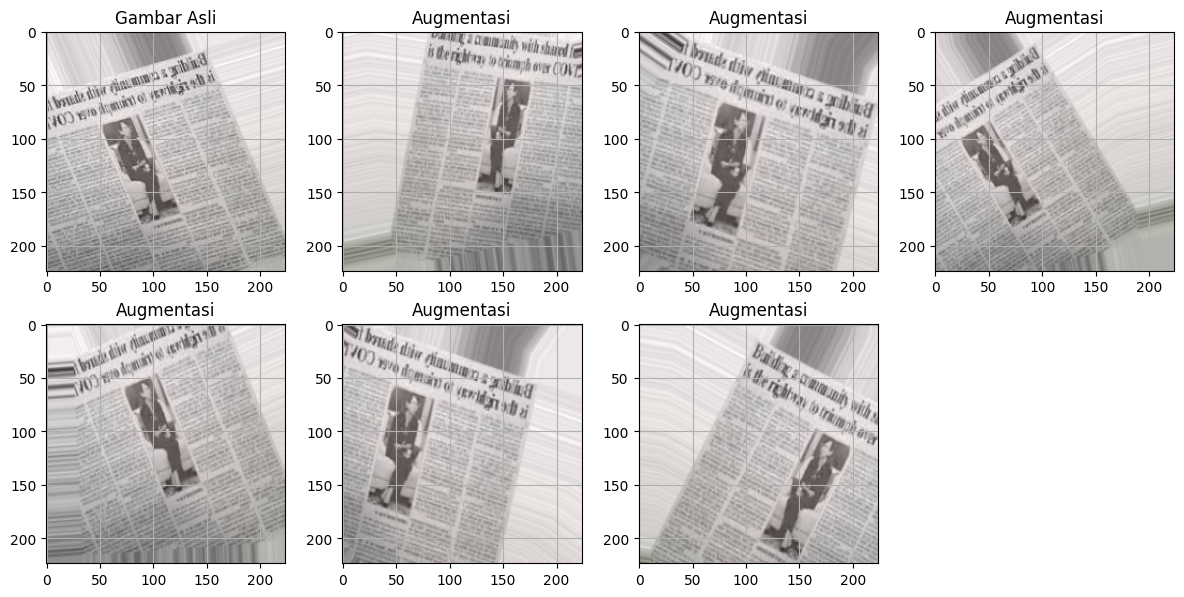

In [15]:
# train_generator
images, labels = next(train_generator)

# gambar (tanpa augmentasi)
original_image = images[0]

# Tampilkan gambar asli
plt.figure(figsize=(12, 6))
plt.subplot(2, 4, 1)
plt.imshow(original_image)
plt.title("Gambar Asli")
plt.axis('on')  
plt.grid(True) 

# gambar
for i in range(6):
    augmented_image = train_datagen.random_transform(original_image)
    # Tampilkan hasil augmentasi
    plt.subplot(2, 4, i + 2)
    plt.imshow(augmented_image)
    plt.title("Augmentasi")
    plt.axis('on')  
    plt.grid(True) 

plt.tight_layout()
plt.show()


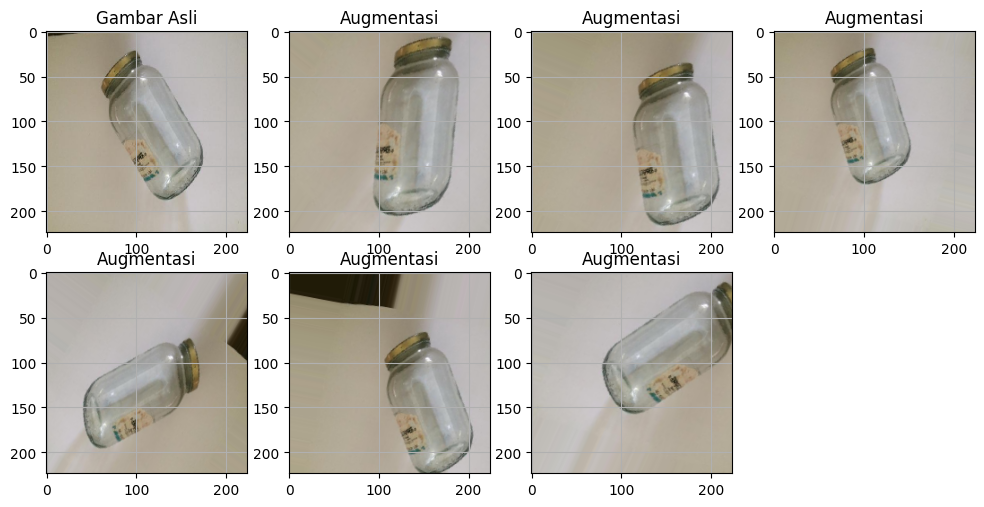

In [16]:
# Memuat satu gambar dari di
img_path = 'C:/Users/riski/Documents/Anorganik/split_anorganik2a/train_dir/glass/glass_169.jpg'  
img = load_img(img_path,target_size=(224, 224))
x = img_to_array(img)
x = np.expand_dims(x, axis=0)  # dimensi
# gambar asli
plt.figure(figsize=(12,12))
plt.subplot(4, 4, 1)
plt.imshow(img)
plt.title("Gambar Asli")
plt.axis('on')  
plt.grid(True)  

#  hasil augmentasi
for i in range(6):
    augmented_img = next(train_datagen.flow(x, batch_size=1))[0]
    plt.subplot(4, 4, i+2)
    plt.imshow(augmented_img)
    plt.title("Augmentasi")#{i+1}
    plt.axis('on')  
    plt.grid(True)  
   
plt.show()

In [17]:
# akses base mod
base_model_densenet = DenseNet169(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

#Freeze the base model
base_model_densenet.trainable = False

# build modelnya
model_densenet = Sequential([
    base_model_densenet,
    GlobalAveragePooling2D(),
    Dense(5, activation='softmax'),
])

print("build model")
model_densenet.compile(optimizer=Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])
model_densenet.summary()

build model
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet169 (Functional)    (None, 7, 7, 1664)        12642880  
                                                                 
 global_average_pooling2d (  (None, 1664)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 5)                 8325      
                                                                 
Total params: 12651205 (48.26 MB)
Trainable params: 8325 (32.52 KB)
Non-trainable params: 12642880 (48.23 MB)
_________________________________________________________________


In [18]:
# Membuat callback ModelCheckpoint
checkpoint = ModelCheckpoint(
    filepath='best_model_densenet169_32302a.keras', 
    monitor='val_loss',       # Metrik yang akan dipantau
    save_best_only=True,      # menyimpan model performa terbaik
    mode='min',               # Mode 'min'  meminimalkan val_loss
    verbose=1                 # 
)
#mulai
start_time = time.time()
# training model dengan menambahkan checkpoint
history = model_densenet.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator,
    verbose=2,
    callbacks=[checkpoint]    
)
# selesai
end_time = time.time()

# Hitung total waktu training
total_time = end_time - start_time

# format jam:menit:detik
hours, rem = divmod(total_time, 3600)
minutes, seconds = divmod(rem, 60)

#tampilkan
print(f"Waktu training : {int(hours)} jam {int(minutes)} menit {int(seconds)} detik")


Epoch 1/30

Epoch 1: val_loss improved from inf to 0.57175, saving model to best_model_densenet169_32302a.keras
89/89 - 305s - loss: 0.9826 - accuracy: 0.6105 - val_loss: 0.5717 - val_accuracy: 0.7932 - 305s/epoch - 3s/step
Epoch 2/30

Epoch 2: val_loss improved from 0.57175 to 0.44352, saving model to best_model_densenet169_32302a.keras
89/89 - 165s - loss: 0.5739 - accuracy: 0.7945 - val_loss: 0.4435 - val_accuracy: 0.8244 - 165s/epoch - 2s/step
Epoch 3/30

Epoch 3: val_loss improved from 0.44352 to 0.38237, saving model to best_model_densenet169_32302a.keras
89/89 - 200s - loss: 0.4659 - accuracy: 0.8345 - val_loss: 0.3824 - val_accuracy: 0.8612 - 200s/epoch - 2s/step
Epoch 4/30

Epoch 4: val_loss improved from 0.38237 to 0.35796, saving model to best_model_densenet169_32302a.keras
89/89 - 192s - loss: 0.4160 - accuracy: 0.8504 - val_loss: 0.3580 - val_accuracy: 0.8555 - 192s/epoch - 2s/step
Epoch 5/30

Epoch 5: val_loss improved from 0.35796 to 0.33821, saving model to best_model_d

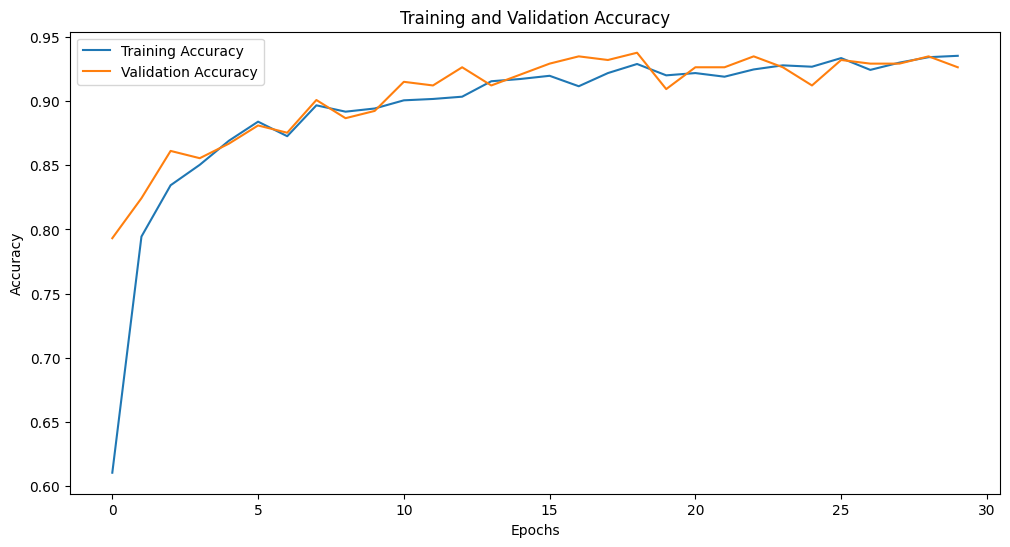

In [20]:
def plot_training_validation_accuracy(history):
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

plot_training_validation_accuracy(history)

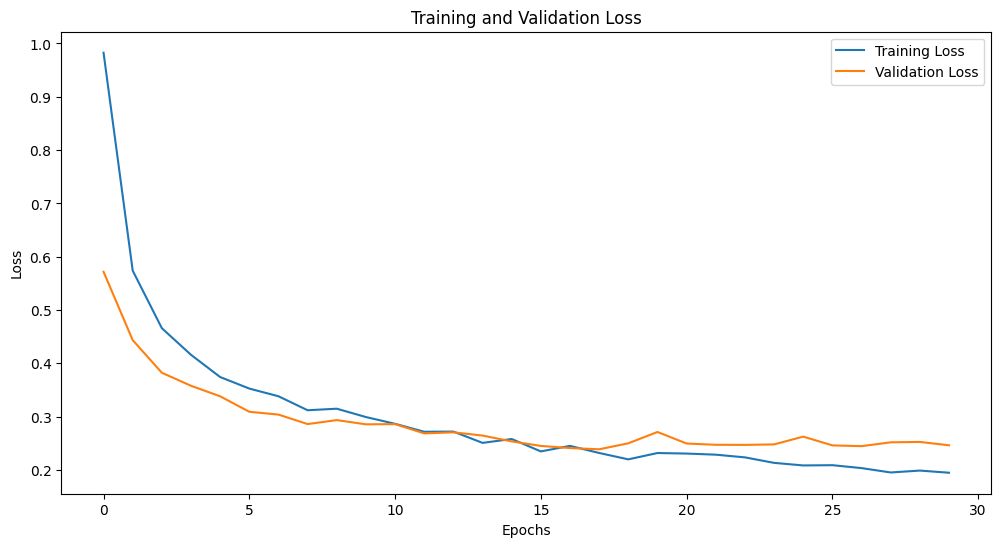

In [21]:
def plot_training_validation_loss(history):
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_training_validation_loss(history)

In [64]:
# Simpan model yang sudah dilatih
# model_densenet.save('densenet121_trained10_model.h5')
model_densenet.save('densenet121_trained5_model.keras')

12/12 [==============================] - 16s 1s/step


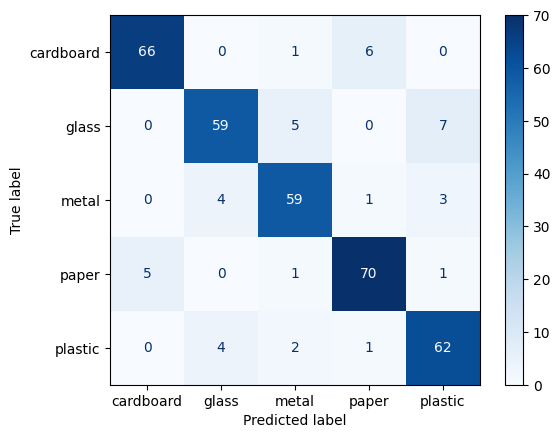

Accuracy: 0.89
Recall: 0.88
Precision: 0.88
F1-score: 0.88

Classification Report:
              precision    recall  f1-score   support

   cardboard       0.93      0.90      0.92        73
       glass       0.88      0.83      0.86        71
       metal       0.87      0.88      0.87        67
       paper       0.90      0.91      0.90        77
     plastic       0.85      0.90      0.87        69

    accuracy                           0.89       357
   macro avg       0.88      0.88      0.88       357
weighted avg       0.89      0.89      0.89       357



In [22]:
y_pred = model_densenet.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# Dapatkan label yang benar
y_true = test_generator.classes

# Generate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# tampilk confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.show()


accuracy = accuracy_score(y_true, y_pred_classes)
recall = recall_score(y_true, y_pred_classes, average='macro')
precision = precision_score(y_true, y_pred_classes, average='macro')
f1 = f1_score(y_true, y_pred_classes, average='macro')

# tampilkan nilai
print(f"Accuracy: {accuracy:.2f}")
print(f"Recall: {recall:.2f}")
print(f"Precision: {precision:.2f}")
print(f"F1-score: {f1:.2f}")

# classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_names))



In [12]:
import keras
import tensorflow as tf
print(keras.__version__)
print(tf.__version__)

2.15.0
2.15.0


In [ ]:
base_model_densenet.summary()

In [16]:
pip install Pillow==9.4.0

   ---------------------------------------- 0.0/2.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.5 MB ? eta -:--:--
    --------------------------------------- 0.1/2.5 MB 1.1 MB/s eta 0:00:03
   -- ------------------------------------- 0.2/2.5 MB 1.8 MB/s eta 0:00:02
   ----- ---------------------------------- 0.3/2.5 MB 2.2 MB/s eta 0:00:01
   ----- ---------------------------------- 0.3/2.5 MB 2.4 MB/s eta 0:00:01
   --------- ------------------------------ 0.6/2.5 MB 2.5 MB/s eta 0:00:01
   ----------- ---------------------------- 0.7/2.5 MB 2.6 MB/s eta 0:00:01
   -------------- ------------------------- 0.9/2.5 MB 2.8 MB/s eta 0:00:01
   ---------------- ----------------------- 1.0/2.5 MB 2.8 MB/s eta 0:00:01
   ------------------ --------------------- 1.2/2.5 MB 2.9 MB/s eta 0:00:01
   --------------------- ------------------ 1.3/2.5 MB 2.9 MB/s eta 0:00:01
   ---------------------- ----------------- 1.4/2.5 MB 2.8 MB/s eta 0:00:01
   -----------------------

In [15]:
pip install matplotlib

  Using cached contourpy-1.2.1-cp310-cp310-win_amd64.whl.metadata (5.8 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
     ---------------------------------------- 0.0/165.9 kB ? eta -:--:--
     ------- ------------------------------- 30.7/165.9 kB 1.4 MB/s eta 0:00:01
     ---------------------------- --------- 122.9/165.9 kB 1.8 MB/s eta 0:00:01
     -------------------------------------- 165.9/165.9 kB 2.0 MB/s eta 0:00:00
   ---------------------------------------- 0.0/8.0 MB ? eta -:--:--
   ---------------------------------------- 0.1/8.0 MB 2.0 MB/s eta 0:00:04
    --------------------------------------- 0.2/8.0 MB 2.1 MB/s eta 0:00:04
   - -------------------------------------- 0.3/8.0 MB 2.4 MB/s eta 0:00:04
   - -------------------------------------- 0.4/8.0 MB 2.2 MB/s eta 0:00:04
   -- ------------------------------------- 0.5/8.0 MB 2.2 MB/s eta 0:00:04
   -- ------------------------------------- 0.6/8.0 MB 2.3 MB/s eta 0:00:04
   --- ----------------

In [3]:
import tensorflow as tf
tf.get_logger().setLevel('ERROR')

In [66]:
base_model_densenet.summary()

Model: "densenet121"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 zero_padding2d_12 (ZeroPad  (None, 230, 230, 3)          0         ['input_7[0][0]']             
 ding2D)                                                                                          
                                                                                                  
 conv1/conv (Conv2D)         (None, 112, 112, 64)         9408      ['zero_padding2d_12[0][0]']   
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1/conv[0][0]']